# AIR Centre - Kaggle Competition
## Automatic Identification of Internal Waves 

by Emanuel Castanho

In [ ]:
# CoLab: Install dependencies

!pip install ultralytics==8.2.82

In [8]:
# Libraries

import torch
import os
from ultralytics import YOLO
import pandas as pd
import shutil
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, ConfusionMatrixDisplay

In [2]:
# Defined functions

def create_folder(folder_path):
    if not os.path.exists(folder_path):
        os.mkdir(folder_path)

In [3]:
# Check if GPU is available

if torch.cuda.is_available():
    print("GPU available")
    torch.cuda.set_device(0)
    device = 0 # Single GPU, there is support for multiple
else:
    print("GPU not available, using CPU")
    torch.cuda.set_device(-1)
    device = "cpu"

GPU not available, using CPU


In [4]:
# Create data and internal-waves folders

data_folder_path = "data"
create_folder(data_folder_path)

iwaves_folder_path = os.path.join(data_folder_path, "internal-waves")
create_folder(iwaves_folder_path)

In [ ]:
# Download dataset from Kaggle, move and unzip

!kaggle competitions download -c internal-waves
!mv internal-waves.zip {data_folder_path}
!unzip {data_folder_path}/internal-waves.zip -d {iwaves_folder_path}
!rm -r {data_folder_path}/internal-waves.zip

In [ ]:
# Organise data for YOLO v8 classification

# 0 - no internal wave
# 1 - internal wave

# ID - Image ID
# GT - Ground Truth

# internal-waves_fmt/
# |
# |-- train/
# |   |-- 1/
# |   |   |-- ID_GT.png
# |   |   |-- ID_GT.png
# |   |   |-- ...
# |   |
# |   |-- 0/
# |   |   |-- ID_GT.png
# |   |   |-- ID_GT.png
# |   |   |-- ...
# |
# |-- val/
# |   |-- 1/
# |   |   |-- ...
# |   |
# |   |-- 0/
# |   |   |-- ...

iwaves_fmt_folder_path = os.path.join(data_folder_path, "internal-waves_fmt")
create_folder(iwaves_fmt_folder_path)

train_fmt_folder_path = os.path.join(iwaves_fmt_folder_path, "train")
create_folder(train_fmt_folder_path)
train_pos_folder_path = os.path.join(train_fmt_folder_path, "1")
create_folder(train_pos_folder_path)
train_neg_folder_path = os.path.join(train_fmt_folder_path, "0")
create_folder(train_neg_folder_path)

val_fmt_folder_path = os.path.join(iwaves_fmt_folder_path, "val")
create_folder(val_fmt_folder_path)
val_pos_folder_path = os.path.join(val_fmt_folder_path, "1")
create_folder(val_pos_folder_path)
val_neg_folder_path = os.path.join(val_fmt_folder_path, "0")
create_folder(val_neg_folder_path)

In [ ]:
# Open Train csv with id and ground truth

train_csv_path = os.path.join(iwaves_folder_path, "train.csv")
train_df = pd.read_csv(train_csv_path)
train_df.head()

In [ ]:
# Split some Train to use as Validation (30%)

id_train, id_val, gt_train, gt_val = train_test_split(train_df["id"], train_df["ground_truth"], 
                                                      test_size=0.30, random_state=42)

In [ ]:
# Copy Train images to new Train

for id, gt in zip(id_train, gt_train):
    src = os.path.join(iwaves_folder_path, "images_train-20240709T094004Z-001", 
                       "images_train", str(id)+".png")
    if gt == 1:
        dst = os.path.join(train_pos_folder_path, str(id)+'_'+str(gt)+".png")
    else:
        dst = os.path.join(train_neg_folder_path, str(id)+'_'+str(gt)+".png") 
    shutil.copy(src, dst) 

In [ ]:
# Copy Train images to Validation

for id, gt in zip(id_val, gt_val):
    src = os.path.join(iwaves_folder_path, "images_train-20240709T094004Z-001", 
                       "images_train", str(id)+".png")
    if gt == 1:
        dst = os.path.join(val_pos_folder_path, str(id)+'_'+str(gt)+".png")
    else:
        dst = os.path.join(val_neg_folder_path, str(id)+'_'+str(gt)+".png") 
    shutil.copy(src, dst) 

In [ ]:
# Configure TensorBoard
# If using CoLab, open on Chrome

%load_ext tensorboard
%tensorboard --logdir runs

In [ ]:
# Load pre-trained YOLO model

model = YOLO(os.path.join("pre-trained_models", "yolov8x-cls.pt"))

In [ ]:
# Train the model

train_results = model.train(data=iwaves_fmt_folder_path, epochs=100, seed=42, device=device)

In [ ]:
# Inference in the Test dataset

# Import best model

best_model_path = os.path.join("runs", "classify", "train", "weights", "best.pt")
best_model = YOLO(best_model_path)

# Predict

test_folder_path = os.path.join(iwaves_folder_path, "images_test-20240709T093512Z-001", "images_test")
test_results = best_model.predict(source=test_folder_path, save=True, device=device)

In [ ]:
# Save prediction results to CSV

image_id = []
image_prediction = []

for result in test_results:
    image_id.append(os.path.basename(result.path)[:-4])
    image_prediction.append(result.probs.top1)
  
submission_df = pd.DataFrame({"id": image_id, "predicted": image_prediction})
submission_df.sort_values(by="id", inplace=True, lambda x: x.astype(int))
submission_df.to_csv("submission.csv", index=False)

In [5]:
# Compare submission with given solution

# Open given solution
solution_csv_path = os.path.join(iwaves_folder_path, "solution.csv")
solution_df = pd.read_csv(solution_csv_path)
y_test = solution_df["ground_truth"]

# Open submission
submission_csv_path = "submission.csv"
submission_df = pd.read_csv(submission_csv_path)
y_pred = submission_df["predicted"]

In [12]:
# Basic metrics

print("Precision: " + "{0:.2f}".format(precision_score(y_test, y_pred, average="macro")))
print("Accuracy: " + "{0:.2f}".format(accuracy_score(y_test, y_pred)))
print("Recall: " + "{0:.2f}".format(recall_score(y_test, y_pred, average="macro")))
print("F1-Score: " + "{0:.2f}".format(f1_score(y_test, y_pred, average="macro")))

Precision: 0.97
Accuracy: 0.97
Recall: 0.97
F1-Score: 0.97


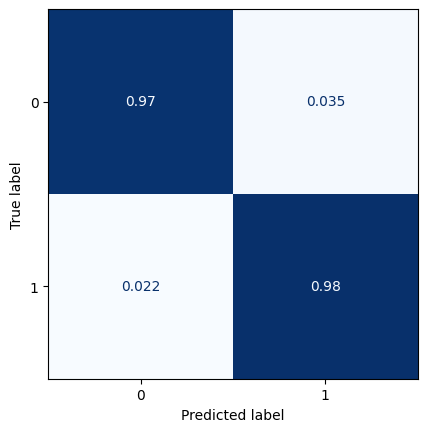

In [11]:
# Confusion matrix

ConfusionMatrixDisplay.from_predictions(y_test, y_pred, normalize="true", cmap="Blues", colorbar=False)
plt.show()